#### The Besag-York-Mollie Model for Spatial Data -SVI and Opioid data

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

In [2]:
# these libraries are not dependencies of pymc

import networkx as nx
import nutpie

In [3]:
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Demonstrating the BYM model on Opioid Mortality data

In [4]:
import pandas as pd
import geopandas as gpd

In [5]:
df = gpd.read_file("/home/h6x/git_projects/universal-experiment-lab/experiment_2_bym_modeling/bym_svi_opioid_data/county_svi_county_mortality/svi_mortality_2018.shp")

In [6]:
df.head()

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry
0,15.4,4.2,29372.0,11.3,7.1,14.6,24.2,19.3,7.5,0.8,...,18.4,1.4,5.6,1.0,10.9,01,01001,AL,55200,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,14.4,4.1,22656.0,19.8,11.0,17.8,23.4,14.2,7.0,1.7,...,25.2,1.6,4.2,0.9,19.9,01,01009,AL,57645,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."
2,23.5,6.7,20430.0,15.4,10.2,19.0,22.8,17.7,10.5,0.5,...,26.2,1.8,7.8,1.6,8.8,01,01013,AL,20025,"POLYGON ((-86.90894 31.96167, -86.87498 31.961..."
3,18.6,8.8,24706.0,15.9,9.4,16.8,21.9,20.8,10.4,1.0,...,14.7,1.7,5.8,2.7,15.8,01,01015,AL,115098,"POLYGON ((-86.14622 33.70218, -86.14577 33.704..."
4,16.6,5.0,22827.0,18.6,10.8,18.9,20.7,16.7,9.7,0.1,...,14.0,3.0,7.3,1.5,11.9,01,01017,AL,33826,"POLYGON ((-85.59343 32.89727, -85.59333 32.984..."


#### First study a single state

In [7]:
# get unique state names
states = df['ST_ABBR'].unique()
states

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID',
       'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
       'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND',
       'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
       'VA', 'WA', 'WV', 'WI', 'WY', 'HI', 'DC'], dtype=object)

In [8]:
# drop rows with state name 'AL' or 'AK'
# df = df[~df['ST_ABBR'].isin(['AK','HI','MA','WA'])]


In [9]:
# state = 'TX'

In [13]:
# filter by state
# df_state = df[df['ST_ABBR'] == state]
# get the rows where ST_ABBR is 'TX','AR','OK','LA','NM']
df_state = df[df['ST_ABBR'].isin(['TX','AR','OK','LA','NM'])]

In [14]:
# df_state = df

In [15]:
df_state.shape

(502, 22)

In [16]:
# get number of unique counties 
n_counties = df_state['FIPS'].nunique()
print(n_counties)

502


In [17]:
# get the county names to a list
county_fips_before = df_state['FIPS'].tolist()

<Axes: >

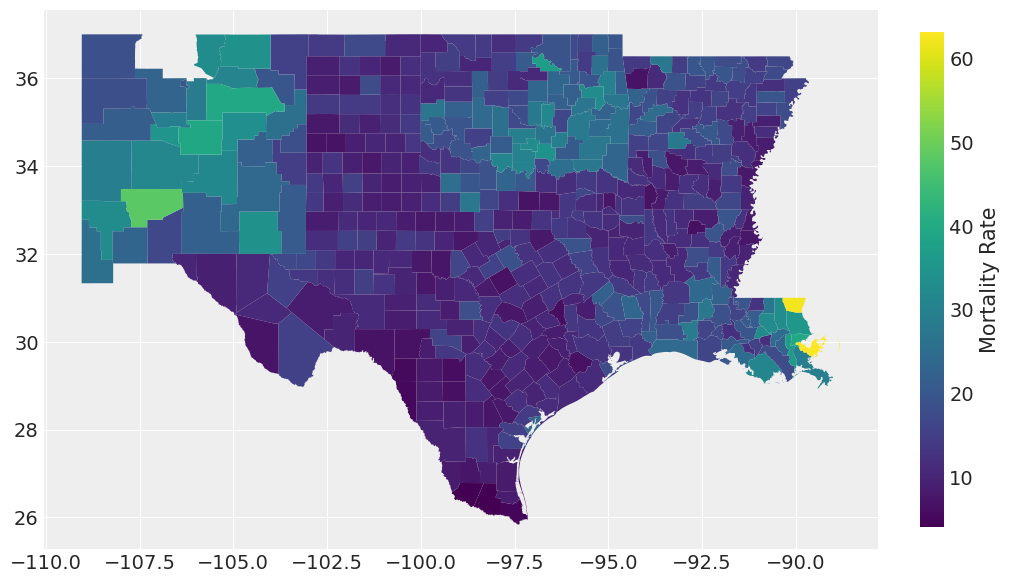

In [18]:
# Assuming df_state is a GeoDataFrame with 'NOD' column and valid geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with customizations
df_state.plot(
    column='NOD', 
    ax=ax, 
    legend=True, 
    # cmap='OrRd',  # Color map
    legend_kwds={'shrink': 0.5, 'label': "Mortality Rate"}  # Adjust legend size
)

<Axes: >

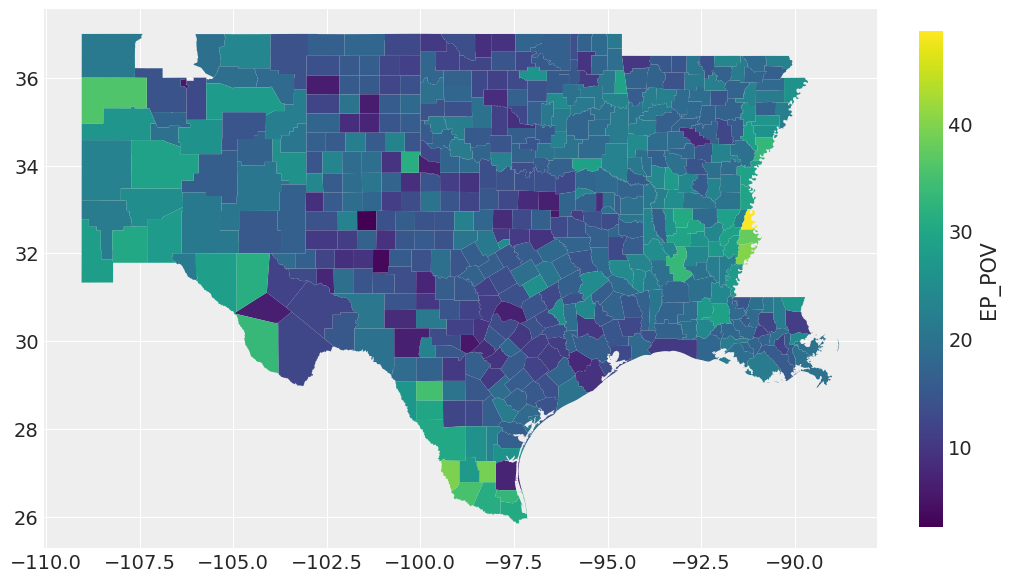

In [19]:
# Assuming df_state is a GeoDataFrame with 'NOD' column and valid geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with customizations
df_state.plot(
    column='EP_POV', 
    ax=ax, 
    legend=True, 
    # cmap='OrRd',  # Color map
    legend_kwds={'shrink': 0.5, 'label': "EP_POV"}  # Adjust legend size
)

In [20]:
def generate_adjacent_counties(dataframe, variable_name):
    """Generate adjacent counties based on given dataframe and variable."""
    filtered_df = dataframe
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()
    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)
    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()
    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county', right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')
    return adjacencies_list, merged_df, county_list

#### making the df suitble to identify adjacencies

Creating the sorted ID

In [21]:
df_state['sortedID'] = range(len(df_state))

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
df_state = gpd.GeoDataFrame(df_state, geometry='geometry')
df_state.crs = "EPSG:3395"

In [23]:
df_state.head(3)

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry,sortedID
29,14.9,4.4,23998.0,13.0,6.8,20.1,22.8,18.8,7.7,0.0,...,2.4,5.6,1.4,14.6,05,05009,AR,37288,"POLYGON ((-93.303 36.482, -93.301 36.484, -93....",0
30,23.2,8.0,22411.0,18.0,11.5,18.4,23.7,21.4,10.7,3.0,...,3.5,9.3,1.8,9.0,05,05011,AR,10948,"POLYGON ((-92.382 33.341, -92.382 33.343, -92....",1
31,15.9,5.1,23851.0,14.8,8.9,16.1,24.8,20.2,8.8,1.2,...,3.0,3.9,1.0,22.3,05,05033,AR,62472,"POLYGON ((-94.493 35.759, -94.444 35.758, -94....",2


In [24]:
adjacencies_list, merged_df, county_list = generate_adjacent_counties(df_state, 'test')

In [25]:
adjacencies_list

[[237, 320, 318, 120],
 [138, 117, 126, 233, 123],
 [16, 345, 5, 424, 139, 11],
 [461, 414, 324, 321, 317],
 [236, 10, 136, 17, 124, 122, 239],
 [16, 9, 130, 2, 11],
 [128, 319, 15, 136, 240],
 [123, 380, 128, 15, 236, 382],
 [17, 122, 323, 316, 317, 132, 238],
 [322, 16, 240, 12, 130, 5],
 [232, 236, 4, 382, 13, 17],
 [130, 320, 5, 2, 139, 119, 120],
 [9, 240, 124, 130, 239, 237, 320],
 [232, 10, 415, 324, 17],
 [132, 127, 238, 234],
 [7, 128, 6, 236, 136],
 [322, 172, 9, 345, 5, 2],
 [10, 4, 13, 324, 122, 317, 8],
 [147, 326, 387, 253, 134, 131],
 [104, 215, 142, 143, 141],
 [330, 27, 241, 464, 149],
 [252, 140, 244, 25, 392],
 [144, 243, 252, 140],
 [26, 330, 243, 149],
 [247, 391, 252, 25, 466],
 [252, 21, 24, 392, 466],
 [144, 23, 243],
 [330, 142, 20, 143, 241],
 [215, 141, 242, 146, 251, 390],
 [261, 155],
 [193, 99, 88, 268, 264, 169, 263],
 [43, 32, 36, 47, 65, 164, 161],
 [43, 51, 35, 176, 49, 170, 31, 161],
 [50, 266, 174, 62, 268, 169, 42],
 [63, 165, 345, 175, 424, 173],
 

In [26]:
len(adjacencies_list)  

502

In [27]:
len(merged_df)

502

In [28]:
merged_df.tail(3)

,county,adjacent,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,...,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry,sortedID
499,499,"[479, 301, 500, 495, 445, 457]",34.8,8.4,13350.0,38.0,18.4,13.7,29.5,23.3,...,5.6,14.4,1.6,8.2,48,48507,TX,12131,"POLYGON ((-100.113 28.776, -100.113 28.778, -1...",499
500,500,"[479, 489, 473, 499, 495]",29.8,16.4,18121.0,32.7,22.2,16.3,30.0,23.0,...,8.5,11.9,1.2,8.9,48,48127,TX,10663,"POLYGON ((-100.114 28.648, -100.000 28.647, -1...",500
501,501,"[496, 498, 493, 497, 489]",27.4,11.5,17798.0,25.8,18.8,17.6,31.4,26.0,...,7.7,11.5,0.5,7.4,48,48247,TX,5282,"POLYGON ((-98.954 27.000, -98.954 27.088, -98....",501


In [29]:
merged_df.columns

Index(['county', 'adjacent', 'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP',
       'EP_UNINSUR', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'NOD', 'ST', 'FIPS', 'ST_ABBR', 'E_TOTPOP',
       'geometry', 'sortedID'],
      dtype='object')

In [30]:
merged_df[['county', 'adjacent', 'NOD', 'EP_POV','FIPS']].head()

,county,adjacent,NOD,EP_POV,FIPS
0,0,"[237, 320, 318, 120]",14.6,14.9,05009
1,1,"[138, 117, 126, 233, 123]",9.0,23.2,05011
2,2,"[16, 345, 5, 424, 139, 11]",22.3,15.9,05033
3,3,"[461, 414, 324, 321, 317]",15.6,16.7,05037
4,4,"[236, 10, 136, 17, 124, 122, 239]",15.3,16.8,05045


In [31]:
# get the rows where soetedID is 0,19 in merged_df[['county', 'adjacent', 'NOD', 'EP_POV','FIPS']]
df_state[df_state['sortedID'].isin([468,2076,470])]

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry,sortedID
3007,27.7,6.4,20285.0,18.8,7.3,19.7,20.2,28.5,12.4,7.0,...,1.9,8.4,5.8,39.4,35,35047,NM,28034,"POLYGON ((-105.722 35.823, -105.722 35.827, -1...",468
3018,11.8,6.7,28700.0,23.9,21.5,9.5,30.1,11.7,11.4,7.9,...,5.3,4.3,1.1,13.8,48,48135,TX,158342,"POLYGON ((-102.799 32.086, -102.707 32.087, -1...",470


In [32]:
county_sorted_id = merged_df['county'].tolist()

In [33]:
# add values between 0 and 3107 to list with 0 and length should be 3107
county_sorted_id_all = range(3107)


In [34]:
county_sorted_id_all[-1]

3106

In [35]:
# get the missing values from the list
missing_values = list(set(county_sorted_id_all) - set(county_sorted_id))

# get the missing values from the list
missing_values


[502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 662,
 663,
 664,
 665,
 666,
 667,
 668

To actually get our model running, however, we’ll need to convert the edgelist to an adjacency matrix. The code below performs that task along with some other clean up tasks.

In [37]:
# create adjacency matrix
n = len(merged_df)
# n = n_counties
adjacency_matrix = np.zeros((n, n))

In [38]:
# Fill the adjacency matrix
for county, adjacents in zip(merged_df["county"], merged_df["adjacent"]):
    for adjacent in adjacents:
        print(county, adjacent)
        adjacency_matrix[county, adjacent] = 1


0 237
0 320
0 318
0 120
1 138
1 117
1 126
1 233
1 123
2 16
2 345
2 5
2 424
2 139
2 11
3 461
3 414
3 324
3 321
3 317
4 236
4 10
4 136
4 17
4 124
4 122
4 239
5 16
5 9
5 130
5 2
5 11
6 128
6 319
6 15
6 136
6 240
7 123
7 380
7 128
7 15
7 236
7 382
8 17
8 122
8 323
8 316
8 317
8 132
8 238
9 322
9 16
9 240
9 12
9 130
9 5
10 232
10 236
10 4
10 382
10 13
10 17
11 130
11 320
11 5
11 2
11 139
11 119
11 120
12 9
12 240
12 124
12 130
12 239
12 237
12 320
13 232
13 10
13 415
13 324
13 17
14 132
14 127
14 238
14 234
15 7
15 128
15 6
15 236
15 136
16 322
16 172
16 9
16 345
16 5
16 2
17 10
17 4
17 13
17 324
17 122
17 317
17 8
18 147
18 326
18 387
18 253
18 134
18 131
19 104
19 215
19 142
19 143
19 141
20 330
20 27
20 241
20 464
20 149
21 252
21 140
21 244
21 25
21 392
22 144
22 243
22 252
22 140
23 26
23 330
23 243
23 149
24 247
24 391
24 252
24 25
24 466
25 252
25 21
25 24
25 392
25 466
26 144
26 23
26 243
27 330
27 142
27 20
27 143
27 241
28 215
28 141
28 242
28 146
28 251
28 390
29 261
29 155
30 19

In [39]:
adjacency_matrix.shape

(502, 502)

In [40]:
adjacency_matrix[0][10]

0.0

In [41]:
adjacency_matrix[10][0]

0.0

In [42]:
W_state = adjacency_matrix

We’ll compute the scaling factor.

In [43]:
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)

In [44]:
scaling_factor = scaling_factor_sp(W_state)
scaling_factor

0.46895076661311846

we’ll also explore one predictor variable, the social fragmentation index. 

In [45]:
df_state.head()

,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,EP_CROWD,EP_NOVEH,EP_GROUPQ,NOD,ST,FIPS,ST_ABBR,E_TOTPOP,geometry,sortedID
29,14.9,4.4,23998.0,13.0,6.8,20.1,22.8,18.8,7.7,0.0,...,2.4,5.6,1.4,14.6,05,05009,AR,37288,"POLYGON ((-93.303 36.482, -93.301 36.484, -93....",0
30,23.2,8.0,22411.0,18.0,11.5,18.4,23.7,21.4,10.7,3.0,...,3.5,9.3,1.8,9.0,05,05011,AR,10948,"POLYGON ((-92.382 33.341, -92.382 33.343, -92....",1
31,15.9,5.1,23851.0,14.8,8.9,16.1,24.8,20.2,8.8,1.2,...,3.0,3.9,1.0,22.3,05,05033,AR,62472,"POLYGON ((-94.493 35.759, -94.444 35.758, -94....",2
32,16.7,5.7,24486.0,17.2,7.3,18.0,24.0,19.9,10.8,0.1,...,2.1,7.0,1.3,15.6,05,05037,AR,16998,"POLYGON ((-91.042 35.178, -91.041 35.222, -91....",3
33,16.8,4.7,26163.0,8.7,9.7,11.8,23.5,14.6,7.7,0.7,...,1.9,4.8,4.0,15.3,05,05045,AR,122416,"POLYGON ((-92.598 35.000, -92.596 35.008, -92....",4


In [46]:
df_state.columns

Index(['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'NOD',
       'ST', 'FIPS', 'ST_ABBR', 'E_TOTPOP', 'geometry', 'sortedID'],
      dtype='object')

In [47]:
df_state['NOD'].describe()

count    502.000000
mean      15.445618
std        7.654486
min        4.000000
25%       10.225000
50%       13.250000
75%       18.675000
max       63.200000
Name: NOD, dtype: float64

In [48]:
df_state['EP_POV'].describe()

count    502.000000
mean      17.850000
std        6.195358
min        2.600000
25%       14.100000
50%       17.000000
75%       21.275000
max       48.600000
Name: EP_POV, dtype: float64

In [49]:
y = df_state.NOD.values
E = df_state.E_TOTPOP.values
fragment_index = df_state.EP_POV.values

In [50]:
y.shape

(502,)

In [51]:
# Most census tracts have huge populations
# but a handful have 0. We round
# those up to 10 to avoid triggering an error
# with the log of 0.

E[E < 10] = 10
log_E = np.log(E)

In [52]:
area_idx = df_state["FIPS"].values

In [53]:
coords = {"area_idx": area_idx}

We can get a sense of the spatial structure by visualizing the adjacency matrix. The figure below only captures the relative position of the census tracks. It doesn’t bother with the absolute position so it doesn’t look like New York City. This representation highlights how the city is composed of several regions of uniformly connected areas, a few central hubs that have a huge number of connections, and then a few narrow corridors.

In [56]:
# build the positions of the nodes. We'll only
# generate the positions once so that we can
# compare visualizations from the data to
# the model predictions.
# I found that running spectral layout first
# and passing it to spring layout makes easy to read
# visualizations for large datasets.

G_nyc = nx.Graph(W_state)
pos = nx.spectral_layout(G_nyc)
pos = nx.spring_layout(G_nyc, pos=pos, seed=RANDOM_SEED)

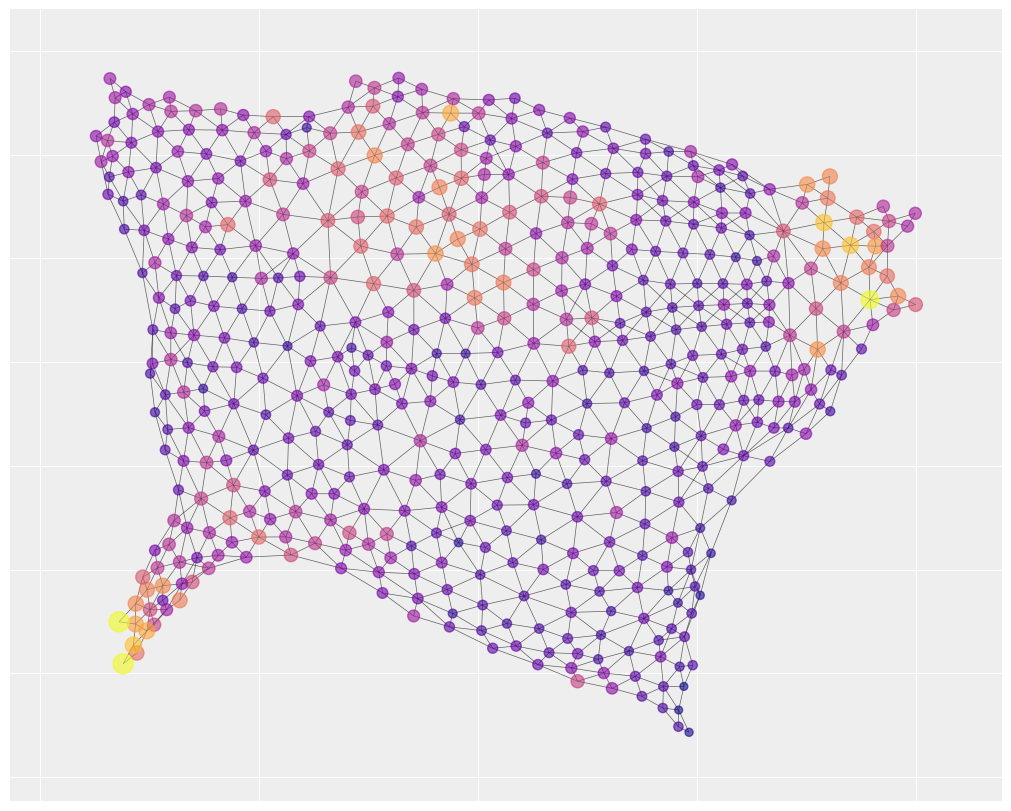

In [79]:
# the spread of the data is pretty high. Most areas have 0 accidents.
# one area has 300. Color-gradient based visualization doesn't work
# well under those conditions. So for the purpose of the color
# we'll cap the accidents at 30 using vmax
#
# however, we'll also make the node size sensitive to the real
# number of accidents. So big yellow nodes have way more accidents
# than small yellow nodes.

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y,
    cmap="plasma",
    vmax=45,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y,
)

We can also visualize the spatial layout of social fragmentation.

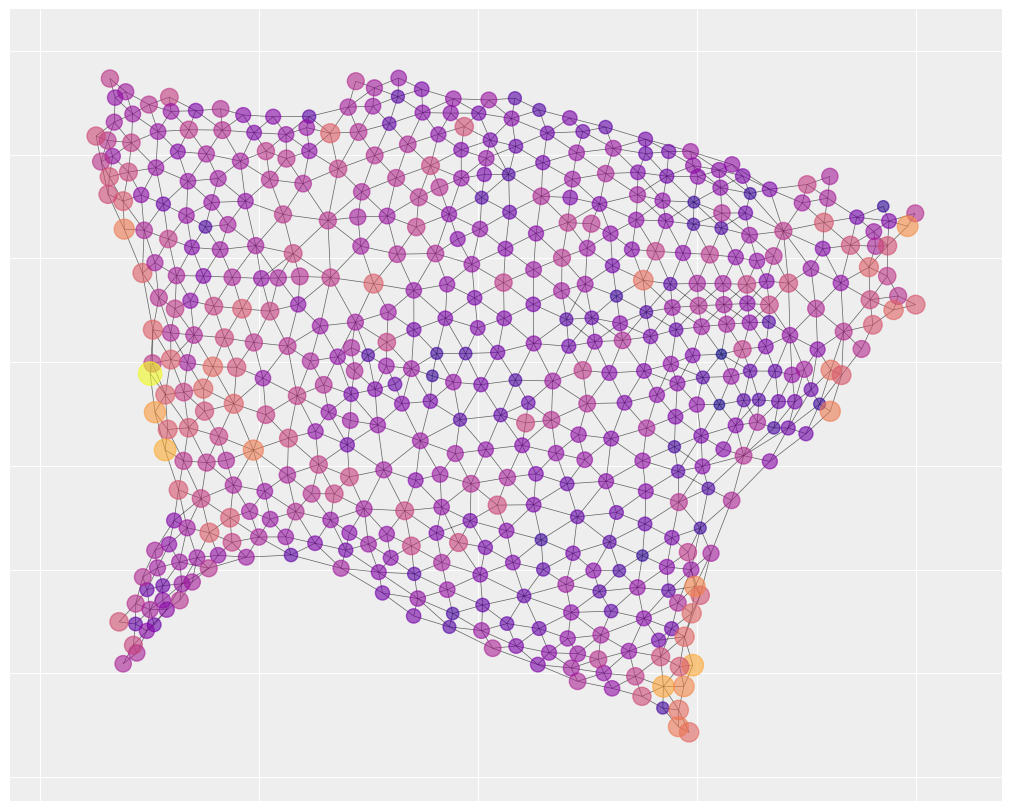

In [59]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=fragment_index,
    cmap="plasma",
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=40 + 5 * fragment_index,
)

Specifying a BYM model with PyMC

In [60]:
with pm.Model(coords=coords) as BYM_model:
    # intercept
    beta0 = pm.Normal("beta0", 0, 1)

    # fragmentation effect
    beta1 = pm.Normal("beta1", 0, 1)

    # independent random effect
    theta = pm.Normal("theta", 0, 1, dims="area_idx")

    # spatially structured random effect
    phi = pm.ICAR("phi", W=W_state, dims="area_idx")

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)

    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pm.Deterministic(
        "mixture", pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi, dims="area_idx"
    )

    # exponential link function to ensure
    # predictions are positive
    mu = pm.Deterministic(
        "mu", pt.exp(log_E + beta0 + beta1 * fragment_index + sigma * mixture), dims="area_idx"
    )

    y_i = pm.Poisson("y_i", mu, observed=y)

Sampling the model

In [73]:
# if you haven't installed nutpie, it's okay to to just delete
# 'nuts_sampler="nutpie"'. The default sampler took roughly 12 minutes on
# my machine.

with BYM_model:
    idata = pm.sample(10000, nuts_sampler="nutpie", random_seed=rng)

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,11000,0,0.13,63
,11000,0,0.13,63
,11000,0,0.13,63
,11000,0,0.14,63


We can evaluate the sampler in several ways. First, it looks like all our chains converged. All parameters have rhat values very close to one.



In [74]:
rhat = az.summary(idata, kind="diagnostics").r_hat.values
sum(rhat > 1.03)

0

Second, the trace plots on all the main parameters look stationary and well-mixed. They also reveal that the mean of rho is somewhere around 0.50, indicating that spatial effects are likely present in the data.


/tmp/ipykernel_3319072/1864615084.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


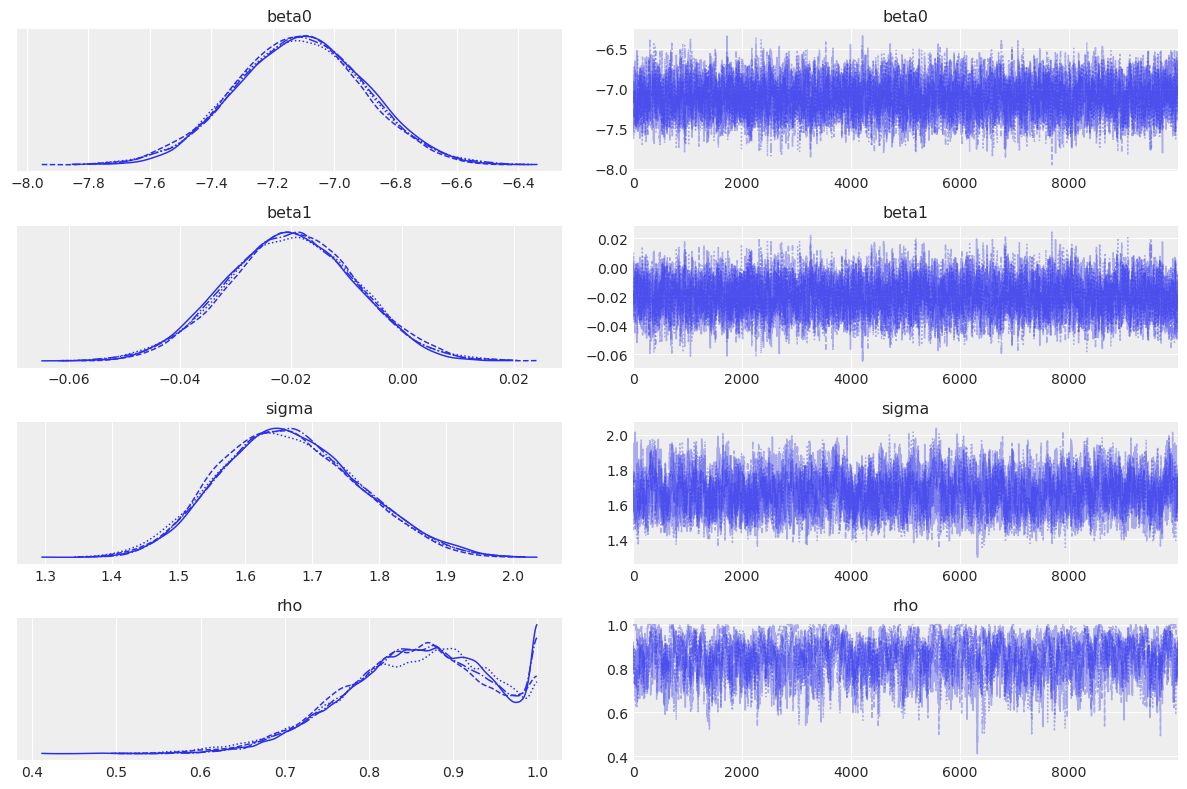

In [75]:
az.plot_trace(idata, var_names=["beta0", "beta1", "sigma", "rho"])
plt.tight_layout();

Posterior predictive checking

In the first case, we’ll visualize only the predictions that come from the spatial component of the model. In other words, we are assuming e =0 and we ignore theta and social fragmentation. Then we’ll overlay our predictions onto the same adjacency map we built earlier.



Sampling: []


/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

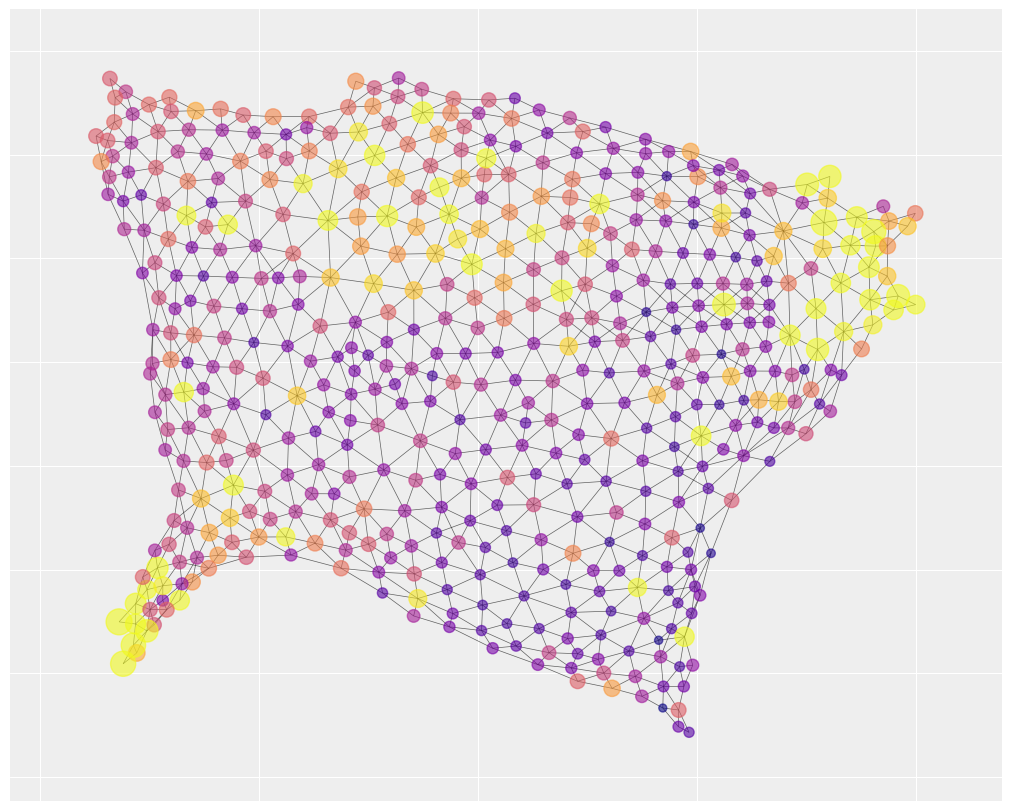

In [77]:
# draw posterio

with pm.do(BYM_model, {"rho": 1.0, "beta1": 0}):
    y_predict = pm.sample_posterior_predictive(
        idata, var_names=["mu", "mixture"], predictions=True, extend_inferencedata=False
    )

y_spatial_pred = y_predict.predictions.mu.mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y_spatial_pred,
    cmap="plasma",
    vmax=50,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_spatial_pred,
)

The resulting picture is called spatial smoothing. Nearby areas tend to be very similar to each other, resulting in distinct neighborhoods of risk. In the dark purple regions, there is little variance and the number of predicted accidents is low, close to zero.

Finally, we might look at the unstructured variance by assuming e=0. If our model managed to partition variance successfully, there should not be too many spatial clusters left over in the unstructured variance. Instead, variance should be scattered all over the map.

Sampling: []


/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

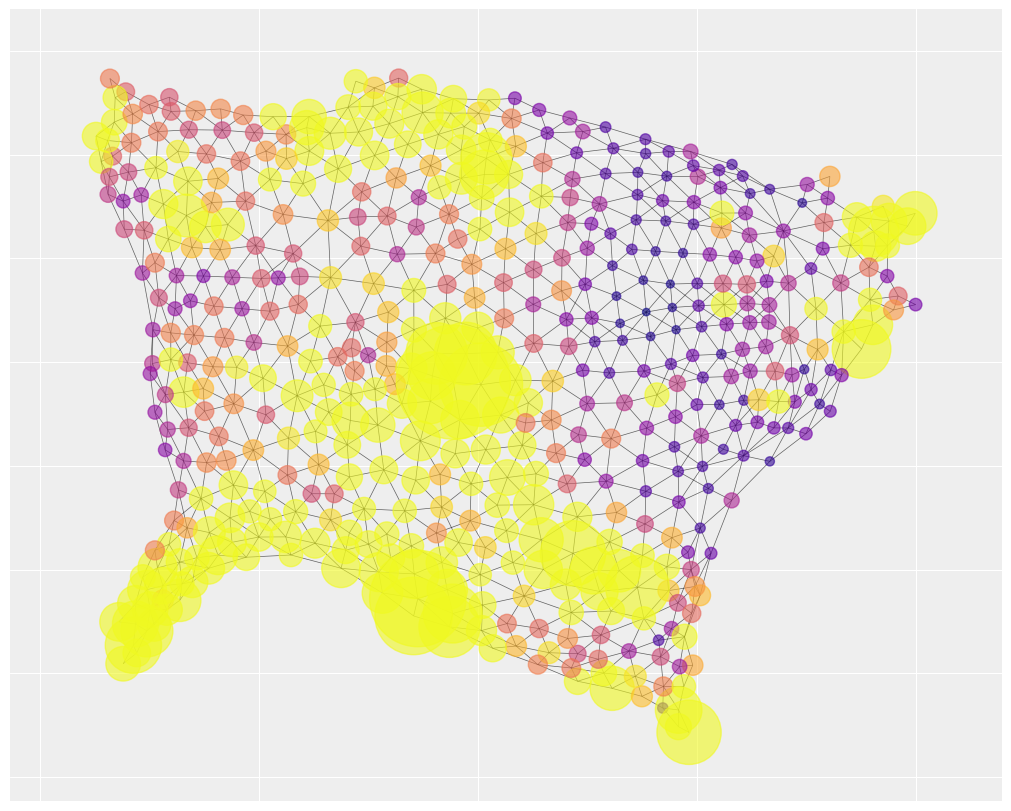

In [81]:
with pm.do(BYM_model, {"rho": 0.0, "beta1": 0}):
    y_predict = pm.sample_posterior_predictive(
        idata, var_names=["mu", "mixture"], predictions=True, extend_inferencedata=False
    )

y_unspatial_pred = y_predict.predictions.mu.mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y_unspatial_pred,
    cmap="plasma",
    vmax=80,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_unspatial_pred,
)